# Bird Prediction Analysis - Target Species Detection

**Objective:** Analyze PERCH and BirdNET predictions to identify detections of the three known aviary species.

**Known Aviary Species:**
- Black-headed weaver (*Ploceus melanocephalus*) - 5 individuals
- Eurasian hoopoe (*Upupa epops*) - 2 individuals  
- Red-billed quelea (*Quelea quelea*) - 61 individuals

## Step 1: Setup and Load Data

In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
BASE_DIR = Path(r"c:\Users\Casper\Documents\GitHub\zoo-acoustics")
DATA_DIR = BASE_DIR / "data" / "fl_gaia_zoo_congo_15aug25_data"
METADATA_FILE = DATA_DIR / "fl_gaia_zoo_congo_15aug25_data__fl_gaia_zoo_congo_15aug25_data_metadata_speechless_predictions.xlsx"

# Target species
TARGET_SPECIES = {
    'Ploceus melanocephalus': 'Black-headed weaver',
    'Upupa epops': 'Eurasian hoopoe',
    'Quelea quelea': 'Red-billed quelea'
}

# Load data
df = pd.read_excel(METADATA_FILE)
print(f"Loaded {len(df):,} audio clips")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")

Loaded 42,872 audio clips
Date range: 2025-08-08 11:00:02 to 2025-08-15 07:55:02


## Step 2: Clean Prediction Data

Extract species names from predictions (remove confidence scores from the strings).

In [29]:
# Remove rows with speech_removed or file_missing
initial_count = len(df)
df = df[~df['MIT_AST_label'].isin(['speech_removed', 'file_missing'])].copy()
removed_count = initial_count - len(df)

print(f"Removed {removed_count:,} rows with invalid labels")
print(f"Remaining clips: {len(df):,}")

Removed 15,725 rows with invalid labels
Remaining clips: 27,147


## Step 3: Clean Prediction Data

Extract species names from predictions (remove confidence scores from the strings).

In [30]:
# Function to extract clean species name from prediction string
def extract_species(pred_string):
    if pd.isna(pred_string):
        return None
    # Format: "Genus species Common Name (confidence)"
    # Extract just "Genus species"
    parts = pred_string.split()
    if len(parts) >= 2:
        return f"{parts[0]} {parts[1]}"
    return None

# Clean prediction columns
df['perch_species'] = df['perch_prediction'].apply(extract_species)
df['birdnet_species'] = df['birdnet_prediction'].apply(extract_species)

print("Cleaned prediction data")
print(f"PERCH predictions: {df['perch_species'].notna().sum():,} clips")
print(f"BirdNET predictions: {df['birdnet_species'].notna().sum():,} clips")

Cleaned prediction data
PERCH predictions: 27,147 clips
BirdNET predictions: 15,494 clips


## Step 4: PERCH Model Analysis

In [31]:
print("PERCH Model - Target Species Detections\n")

perch_results = {}
for species, common in TARGET_SPECIES.items():
    count = (df['perch_species'] == species).sum()
    perch_results[species] = count
    print(f"{common}: {count:,} detections")

total_perch = sum(perch_results.values())
print(f"\nTotal: {total_perch:,} detections ({total_perch/len(df)*100:.1f}% of clips)")

PERCH Model - Target Species Detections

Black-headed weaver: 4,033 detections
Eurasian hoopoe: 60 detections
Red-billed quelea: 30 detections

Total: 4,123 detections (15.2% of clips)


## Step 5: BirdNET Model Analysis

In [32]:
print("BirdNET Model - Target Species Detections\n")

birdnet_results = {}
for species, common in TARGET_SPECIES.items():
    count = (df['birdnet_species'] == species).sum()
    birdnet_results[species] = count
    print(f"{common}: {count:,} detections")

total_birdnet = sum(birdnet_results.values())
print(f"\nTotal: {total_birdnet:,} detections ({total_birdnet/len(df)*100:.1f}% of clips)")

BirdNET Model - Target Species Detections

Black-headed weaver: 5,318 detections
Eurasian hoopoe: 6 detections
Red-billed quelea: 6,002 detections

Total: 11,326 detections (41.7% of clips)


## Step 6: Combined Analysis - Any Target Species Detected

Identify clips where **either** PERCH or BirdNET (or both) detected one of the target species.

In [33]:
# Create flags for each target species
for species, common in TARGET_SPECIES.items():
    df[f'is_{common.lower().replace(" ", "_").replace("-", "_")}'] = (
        (df['perch_species'] == species) | (df['birdnet_species'] == species)
    )

# Overall flag: any target species detected
df['is_target_species'] = df['perch_species'].isin(TARGET_SPECIES.keys()) | df['birdnet_species'].isin(TARGET_SPECIES.keys())

print("Combined Analysis - Target Species Detection\n")

combined_results = {}
for species, common in TARGET_SPECIES.items():
    perch_count = (df['perch_species'] == species).sum()
    birdnet_count = (df['birdnet_species'] == species).sum()
    both_count = ((df['perch_species'] == species) & (df['birdnet_species'] == species)).sum()
    either_count = ((df['perch_species'] == species) | (df['birdnet_species'] == species)).sum()
    
    combined_results[species] = {
        'perch': perch_count,
        'birdnet': birdnet_count,
        'both': both_count,
        'either': either_count
    }
    
    print(f"{common}:")
    print(f"  PERCH only: {perch_count - both_count:,}")
    print(f"  BirdNET only: {birdnet_count - both_count:,}")
    print(f"  Both models: {both_count:,}")
    print(f"  Total unique: {either_count:,}")

total_target_clips = df['is_target_species'].sum()
print(f"\nTotal clips with target species: {total_target_clips:,} ({total_target_clips/len(df)*100:.1f}%)")

Combined Analysis - Target Species Detection

Black-headed weaver:
  PERCH only: 1,564
  BirdNET only: 2,849
  Both models: 2,469
  Total unique: 6,882
Eurasian hoopoe:
  PERCH only: 57
  BirdNET only: 3
  Both models: 3
  Total unique: 63
Red-billed quelea:
  PERCH only: 5
  BirdNET only: 5,977
  Both models: 25
  Total unique: 6,007

Total clips with target species: 12,495 (46.0%)


## Step 7: Summary Statistics

In [34]:
# Create summary dataframe
summary_data = []
for species, common in TARGET_SPECIES.items():
    summary_data.append({
        'Species': common,
        'PERCH': combined_results[species]['perch'],
        'BirdNET': combined_results[species]['birdnet'],
        'Both': combined_results[species]['both'],
        'Total Unique': combined_results[species]['either']
    })

summary_df = pd.DataFrame(summary_data)

print("\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))

# Add totals row
print(f"\nTOTALS:")
print(f"  PERCH: {summary_df['PERCH'].sum():,}")
print(f"  BirdNET: {summary_df['BirdNET'].sum():,}")
print(f"  Both: {summary_df['Both'].sum():,}")
print(f"  Total Unique: {total_target_clips:,}")


SUMMARY TABLE:
            Species  PERCH  BirdNET  Both  Total Unique
Black-headed weaver   4033     5318  2469          6882
    Eurasian hoopoe     60        6     3            63
  Red-billed quelea     30     6002    25          6007

TOTALS:
  PERCH: 4,123
  BirdNET: 11,326
  Both: 2,497
  Total Unique: 12,495


## Step 8: Visualizations

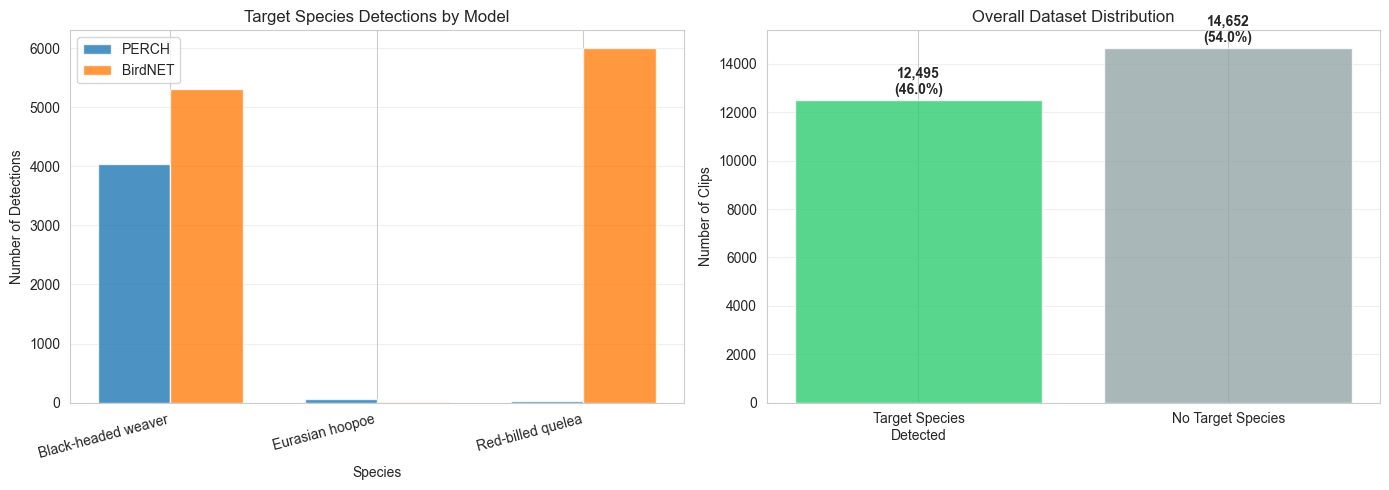

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Detections by species and model
x = np.arange(len(summary_df))
width = 0.35

axes[0].bar(x - width/2, summary_df['PERCH'], width, label='PERCH', alpha=0.8)
axes[0].bar(x + width/2, summary_df['BirdNET'], width, label='BirdNET', alpha=0.8)
axes[0].set_xlabel('Species')
axes[0].set_ylabel('Number of Detections')
axes[0].set_title('Target Species Detections by Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(summary_df['Species'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 2. Overall detection distribution
categories = ['Target Species\nDetected', 'No Target Species']
values = [total_target_clips, len(df) - total_target_clips]
colors = ['#2ecc71', '#95a5a6']

axes[1].bar(categories, values, color=colors, alpha=0.8)
axes[1].set_ylabel('Number of Clips')
axes[1].set_title('Overall Dataset Distribution')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(values):
    axes[1].text(i, v + max(values)*0.01, f'{v:,}\n({v/len(df)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

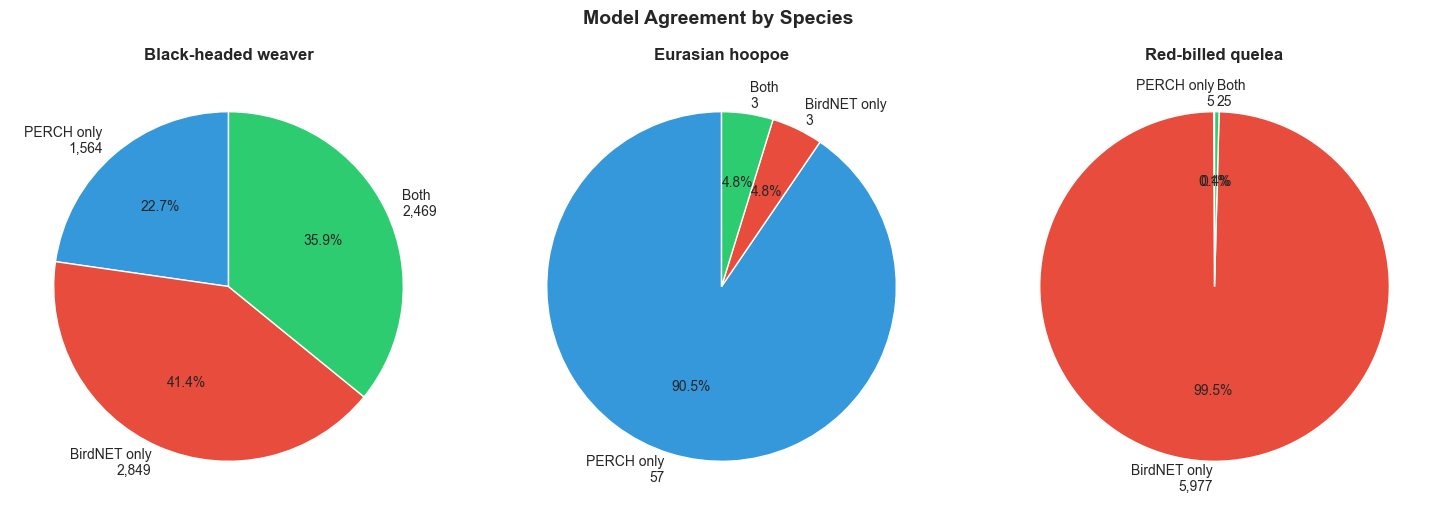

In [36]:
# Detailed breakdown for each species
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, (species, common) in enumerate(TARGET_SPECIES.items()):
    perch_only = combined_results[species]['perch'] - combined_results[species]['both']
    birdnet_only = combined_results[species]['birdnet'] - combined_results[species]['both']
    both = combined_results[species]['both']
    
    sizes = [perch_only, birdnet_only, both]
    labels = [f'PERCH only\n{perch_only:,}', f'BirdNET only\n{birdnet_only:,}', f'Both\n{both:,}']
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    # Only plot if there are detections
    if sum(sizes) > 0:
        axes[idx].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[idx].set_title(f'{common}', fontweight='bold')
    else:
        axes[idx].text(0.5, 0.5, 'No detections', ha='center', va='center')
        axes[idx].set_title(f'{common}', fontweight='bold')
        axes[idx].axis('off')

plt.suptitle('Model Agreement by Species', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Step 9: Export Results

Create a filtered dataset with only target species detections.

In [37]:
# Filter to only clips with target species
target_clips_df = df[df['is_target_species']].copy()

# Add separate columns for better analysis
def get_detected_species(row):
    """Get the species name from either model"""
    if pd.notna(row['perch_species']) and row['perch_species'] in TARGET_SPECIES:
        return row['perch_species']
    elif pd.notna(row['birdnet_species']) and row['birdnet_species'] in TARGET_SPECIES:
        return row['birdnet_species']
    return None

def get_detection_source(row):
    """Identify which model(s) detected the species"""
    perch_detected = pd.notna(row['perch_species']) and row['perch_species'] in TARGET_SPECIES
    birdnet_detected = pd.notna(row['birdnet_species']) and row['birdnet_species'] in TARGET_SPECIES
    
    if perch_detected and birdnet_detected:
        if row['perch_species'] == row['birdnet_species']:
            return "Both"
        else:
            return "Both (different species)"
    elif perch_detected:
        return "PERCH only"
    elif birdnet_detected:
        return "BirdNET only"
    return None

target_clips_df['detected_species'] = target_clips_df.apply(get_detected_species, axis=1)
target_clips_df['detection_source'] = target_clips_df.apply(get_detection_source, axis=1)

print(f"Created filtered dataset with {len(target_clips_df):,} clips\n")
print("Detection sources:")
print(target_clips_df['detection_source'].value_counts().to_string())

Created filtered dataset with 12,495 clips

Detection sources:
detection_source
BirdNET only                8372
Both                        2497
PERCH only                  1169
Both (different species)     457


In [38]:
# Save filtered dataset
output_file = DATA_DIR / "target_species_detections.xlsx"
target_clips_df.to_excel(output_file, index=False)
print(f"Saved: {output_file}")
print(f"Rows: {len(target_clips_df):,} | Columns: {len(target_clips_df.columns)}")

Saved: c:\Users\Casper\Documents\GitHub\zoo-acoustics\data\fl_gaia_zoo_congo_15aug25_data\target_species_detections.xlsx
Rows: 12,495 | Columns: 38


## Updated Dataset Documentation

### New Columns Added

**`detected_species`** (most important)  
Contains the target species name found in the audio clip. This column combines results from both PERCH and BirdNET models, so you don't need to check both prediction columns separately. Values include: "Ploceus melanocephalus", "Upupa epops", or "Quelea quelea".

**`detection_source`**  
Shows which model(s) detected the target species. While the distinction between PERCH and BirdNET may not be relevant for most use cases, this column can help identify clips where both models agree (higher confidence). Values: "PERCH only", "BirdNET only", "Both", or "Both (different species)".

**`perch_species`**  
The cleaned species name predicted by PERCH (without confidence scores). Useful if you need to trace back which model made which prediction.

**`birdnet_species`**  
The cleaned species name predicted by BirdNET (without confidence scores). Useful if you need to trace back which model made which prediction.

### Data Cleaning Applied

- Removed all clips marked as `speech_removed` or `file_missing` in the MIT_AST_label column
- Cleaned prediction strings to extract only species names (removed confidence scores)
- Dataset contains only clips where at least one model detected a target species

### Usage Notes

For most purposes, simply use the **`detected_species`** column to identify which target species was found. If you want higher confidence samples, filter for rows where `detection_source == "Both"`, indicating both models agreed on the detection.